# Exploration of the Contaminants

## Aim
Explore the contaminants found in the violations, examine their distribution and importance.  

In [76]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import datetime


1. slack @fpaupier for db_user and password  
2.1  Download Google SDK:   
        Linux: https://cloud.google.com/sdk/docs/quickstart-linux  
        Windows: https://cloud.google.com/sdk/docs/quickstart-windows  
        macOS: https://cloud.google.com/sdk/docs/quickstart-macos  
2.2 from command line `gcloud auth login`  
2.3 from command line `gcloud init`  
3.1 install https://cloud.google.com/sql/docs/mysql/quickstart-proxy-test#install-proxy  
3.2 __run sql cloud proxy " ./cloud_sql_proxy -instances=safe-water-235819:us-east1:safe-water-db=tcp:3306__ " 
4. pip install MySQLdb  

In [2]:
db_user= 'fdelavy'
password= 'HQgzQ7bZ'
db = pymysql.connect(host="127.0.0.1",    # your host, usually localhost
                     user=db_user,         # your username
                     passwd=password,  # your password
                     port=3307,
                     db = 'safe_water')        # name of the data base

In [3]:
cmd = """
show tables
"""
pd.read_sql(cmd, db)

,Tables_in_safe_water
0,CONTAMINANT_CODES
1,CONTAMINANT_GROUP_CODES
2,DG_LCR_SAMPLE_RESULT
3,ENFORCEMENT_ACTION
4,GEOGRAPHIC_AREA
5,LCR_SAMPLE
6,SERVICE_AREA
7,TREATMENT
8,VIOLATION
9,VIOLATION_ENF_ASSOC


In [4]:
cmd = """
SELECT *
FROM VIOLATION
LIMIT 5
"""
data = pd.read_sql(cmd, db)
data.head().T

,0,1,2,3,4
PWSID,MS0730004,NC0319125,NY1316696,WV3305539,FL3590699
ID,00000444-92b9-428b-9953-461a5adb95ad,000009c8-ac45-4739-9460-06b8b3bc1335,00000e0a-44f5-4809-8fa4-d03c59fe6030,0000114b-e6eb-4548-8b8a-350803638ca9,00001717-1a64-490d-a370-2e782643b91b
VIOLATION_ID,20414,4005,44051,60895,8510219
FACILITY_ID,33301,5004,,,
POPULATION_SERVED_COUNT,2553,60,104,123,773
NPM_CANDIDATE,N,N,N,N,N
PWS_ACTIVITY_CODE,A,I,A,A,I
PWS_DEACTIVATION_DATE,,22-DEC-16,,,22-JUN-12
PRIMARY_SOURCE_CODE,GW,GW,GW,GWP,GW
POP_CAT_5_CODE,2,1,1,1,2


In [5]:
cmd = """
SELECT *
FROM CONTAMINANT_CODES
LIMIT 5
"""
data = pd.read_sql(cmd, db)
data.head().T

,0,1,2,3,4
CODE,0100,0200,0300,0400,0500
NAME,TURBIDITY,SWTR,IESWTR,DBP STAGE 1,FILTER BACKWASH RULE
SCIENTIFIC_NAME,None,None,None,None,None
TYPE_CODE,WQ,RL,RL,RL,RL


In [6]:
# the contaminants are coded. 
# here is a list to decode them:
contamin_codes = pd.read_csv('../../../data/sdwis/contaminant-codes.csv')
# later we will have to link this dataframe to the output of the query.
contamin_codes = contamin_codes[['CODE', 'NAME']] # probably only useful columns
contamin_codes.columns = ['CONTAMINANT_CODE', 'CONTAMINANT_NAME']

# before converting to int type, need to remove the 1***, types of contaminants
contamin_codes.CONTAMINANT_CODE = contamin_codes.CONTAMINANT_CODE.apply(lambda x: ''.join(list(filter(str.isdigit, x))))
contamin_codes.CONTAMINANT_CODE = contamin_codes.CONTAMINANT_CODE.astype(int)

contamin_codes.head().T


,0,1,2,3,4
CONTAMINANT_CODE,100,200,300,400,500
CONTAMINANT_NAME,TURBIDITY,SWTR,IESWTR,DBP STAGE 1,FILTER BACKWASH RULE


In [7]:
# there is another dataset needed to get the position of the water systems
pwsid_pos = pd.read_csv('../../../data/PWSID_coordinates.csv')
pwsid_pos.head().T

,0,1,2,3,4
PWSID,010106001,010109005,010307001,010502002,010502003
ZIP_CODE5,6339,6382,2535,2813,2813
LAT,41.4495,41.4572,41.3456,41.3853,41.3853
LON,-71.9823,-72.1146,-70.7515,-71.6681,-71.6681


## Query to Get the Contaminants and Violations

In [8]:
cmd = """
SELECT
    ID,
    PWSID,
    VIOLATION_ID,
    POPULATION_SERVED_COUNT,
    CONTAMINANT_CODE,
    IS_MAJOR_VIOL_IND,
    COMPL_PER_BEGIN_DATE,
    YEAR(COMPL_PER_BEGIN_DATE) AS year  
FROM
    VIOLATION
WHERE
    IS_HEALTH_BASED_IND = 'Y' AND -- only the health-based violations
    YEAR(COMPL_PER_BEGIN_DATE) > 2008 AND 
    YEAR(COMPL_PER_BEGIN_DATE) < 2017  
"""
hb_violations = pd.read_sql(cmd, db)
print(hb_violations.shape)
print(hb_violations.dtypes)
hb_violations.head().T
# Note: -- Compliance Period Begin Date - represents the beginning of a period of time 
# when a public water system was in violation of a primary drinking water regulation. 
# This may also be the date when the public water system missed a monitoring event or 
# the date when the public water system failed to complete a required action (for example, 
# failing to install new treatment technology by a required date). 


(145903, 8)
ID                         object
PWSID                      object
VIOLATION_ID               object
POPULATION_SERVED_COUNT     int64
CONTAMINANT_CODE            int64
IS_MAJOR_VIOL_IND          object
COMPL_PER_BEGIN_DATE       object
year                        int64
dtype: object


,0,1,2,3,4
ID,00002eb1-1fa2-460a-9be4-be760a5a972e,000032aa-f8bc-43bf-8647-562550360542,0000494d-71f9-4ba2-9605-35149ff4ae91,000058bf-9f47-4f33-91dc-c5f88a7659f8,0001a16c-9f0f-4080-b3e8-6895047604cf
PWSID,AZ0413116,IN2570051,CO0145750,PA4050029,CO0253540
VIOLATION_ID,829,605,2918023,1707384,3024002
POPULATION_SERVED_COUNT,1200,100,270,801,30
CONTAMINANT_CODE,1005,3100,4000,700,3100
IS_MAJOR_VIOL_IND,,,,,
COMPL_PER_BEGIN_DATE,2009-10-01,2009-08-01,2013-01-01,2016-12-01,2011-05-01
year,2009,2009,2013,2016,2011


In [9]:
# we then need to link the violations to the contaminant codes
hb_viol = hb_violations.merge(contamin_codes, on='CONTAMINANT_CODE', how='left')

print(hb_viol.shape)
hb_viol.head().T

(145903, 9)


,0,1,2,3,4
ID,00002eb1-1fa2-460a-9be4-be760a5a972e,000032aa-f8bc-43bf-8647-562550360542,0000494d-71f9-4ba2-9605-35149ff4ae91,000058bf-9f47-4f33-91dc-c5f88a7659f8,0001a16c-9f0f-4080-b3e8-6895047604cf
PWSID,AZ0413116,IN2570051,CO0145750,PA4050029,CO0253540
VIOLATION_ID,829,605,2918023,1707384,3024002
POPULATION_SERVED_COUNT,1200,100,270,801,30
CONTAMINANT_CODE,1005,3100,4000,700,3100
IS_MAJOR_VIOL_IND,,,,,
COMPL_PER_BEGIN_DATE,2009-10-01,2009-08-01,2013-01-01,2016-12-01,2011-05-01
year,2009,2009,2013,2016,2011
CONTAMINANT_NAME,ARSENIC,COLIFORM (TCR),"GROSS ALPHA, EXCL. RADON & U",GROUNDWATER RULE,COLIFORM (TCR)


In [10]:
# we then link this dataset to the position:
viol = hb_viol.merge(pwsid_pos, on='PWSID', how='left')

print(viol.shape)
viol.head().T

# WE NOW HAVE A DATA SET WITH ALL HEALTH-BASED VIOLATIONS FROM 2009-2016,
# with their location and the name of the contaminant: viol

(145903, 12)


,0,1,2,3,4
ID,00002eb1-1fa2-460a-9be4-be760a5a972e,000032aa-f8bc-43bf-8647-562550360542,0000494d-71f9-4ba2-9605-35149ff4ae91,000058bf-9f47-4f33-91dc-c5f88a7659f8,0001a16c-9f0f-4080-b3e8-6895047604cf
PWSID,AZ0413116,IN2570051,CO0145750,PA4050029,CO0253540
VIOLATION_ID,829,605,2918023,1707384,3024002
POPULATION_SERVED_COUNT,1200,100,270,801,30
CONTAMINANT_CODE,1005,3100,4000,700,3100
IS_MAJOR_VIOL_IND,,,,,
COMPL_PER_BEGIN_DATE,2009-10-01,2009-08-01,2013-01-01,2016-12-01,2011-05-01
year,2009,2009,2013,2016,2011
CONTAMINANT_NAME,ARSENIC,COLIFORM (TCR),"GROSS ALPHA, EXCL. RADON & U",GROUNDWATER RULE,COLIFORM (TCR)
ZIP_CODE5,86326,46701,81058,15539,81154


## Plot all violations on a map
* try Altair to plot: https://altair-viz.github.io/index.html
* https://altair-viz.github.io/gallery/one_dot_per_zipcode.html
* else, go back to geopandas: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972


In [14]:
import vega
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

# iris = data.iris()

# alt.Chart(iris).mark_point().encode(
#     x='petalLength',
#     y='petalWidth',
#     color='species'
# )

ValueError: 
To use the 'notebook' renderer, you must install the vega package
and the associated Jupyter extension.
See https://altair-viz.github.io/getting_started/installation.html
for more information.


## Plot some contaminants on the map
preferentially small multiples.

## Violations by date

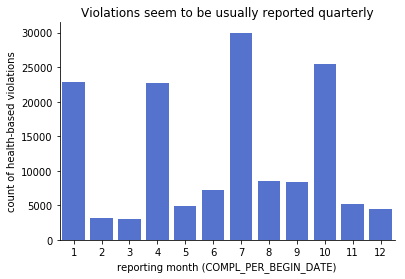

In [49]:
# By MONTH
viol['COMPL_PER_BEGIN_MONTH'] = pd.DatetimeIndex(viol['COMPL_PER_BEGIN_DATE']).month

viol_by_month = viol.groupby('COMPL_PER_BEGIN_MONTH').count().VIOLATION_ID.reset_index()

p = sns.barplot(x='COMPL_PER_BEGIN_MONTH', y='VIOLATION_ID', data=viol_by_month, color='royalblue')
p.set(xlabel='reporting month (COMPL_PER_BEGIN_DATE)', ylabel='count of health-based violations', 
      title = 'Violations seem to be usually reported quarterly')
sns.despine()
plt.show()

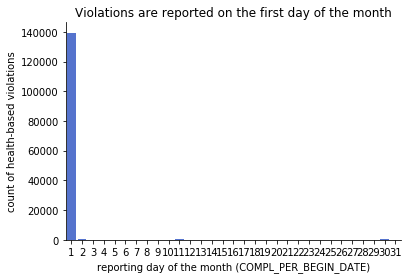

In [48]:
# By DAY
viol['COMPL_PER_BEGIN_DAY'] = pd.DatetimeIndex(viol['COMPL_PER_BEGIN_DATE']).day

viol_by_day = viol.groupby('COMPL_PER_BEGIN_DAY').count().VIOLATION_ID.reset_index()

p = sns.barplot(x='COMPL_PER_BEGIN_DAY', y='VIOLATION_ID', data=viol_by_day, color='royalblue')
p.set(xlabel='reporting day of the month (COMPL_PER_BEGIN_DATE)', ylabel='count of health-based violations', 
      title = 'Violations are reported on the first day of the month')
sns.despine()
plt.show()

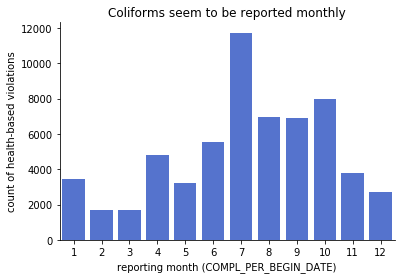

In [55]:
# Looking at the coliforms:
coliforms = viol[viol["CONTAMINANT_CODE"] == 3100]
coliforms.head()

coliforms_by_month = coliforms.groupby('COMPL_PER_BEGIN_MONTH').count().VIOLATION_ID.reset_index()

p = sns.barplot(x='COMPL_PER_BEGIN_MONTH', y='VIOLATION_ID', data=coliforms_by_month, color='royalblue')
p.set(xlabel='reporting month (COMPL_PER_BEGIN_DATE)', ylabel='count of health-based violations', 
      title = 'Coliforms seem to be reported monthly')
sns.despine()
plt.show()

# g = sns.FacetGrid(tips, col="day", height=4, aspect=.5)
# >>> g = g.map(plt.hist, "total_bill", bins=bins)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


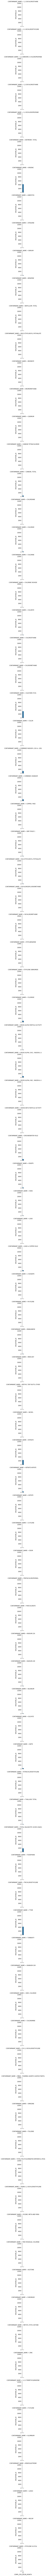

In [67]:
# 
viol_by_month_cont = viol.groupby(['COMPL_PER_BEGIN_MONTH', 'CONTAMINANT_NAME']).count().VIOLATION_ID.reset_index()
# viol_by_month_cont.head().T

g = sns.FacetGrid(viol_by_month_cont, row="CONTAMINANT_NAME")
g = g.map(sns.barplot, 'COMPL_PER_BEGIN_MONTH', 'VIOLATION_ID')
# g = g.map(sns.barplot(x='COMPL_PER_BEGIN_MONTH', y='VIOLATION_ID', data=viol_by_month_cont, color='royalblue'))
# p.set(xlabel='reporting month (COMPL_PER_BEGIN_DATE)', ylabel='count of health-based violations', 
#       title = 'Violations seem to be usually reported quarterly')
sns.despine()
plt.show()

# g = sns.FacetGrid(tips, col="day", height=4, aspect=.5)
# >>> g = g.map(plt.hist, "total_bill", bins=bins)

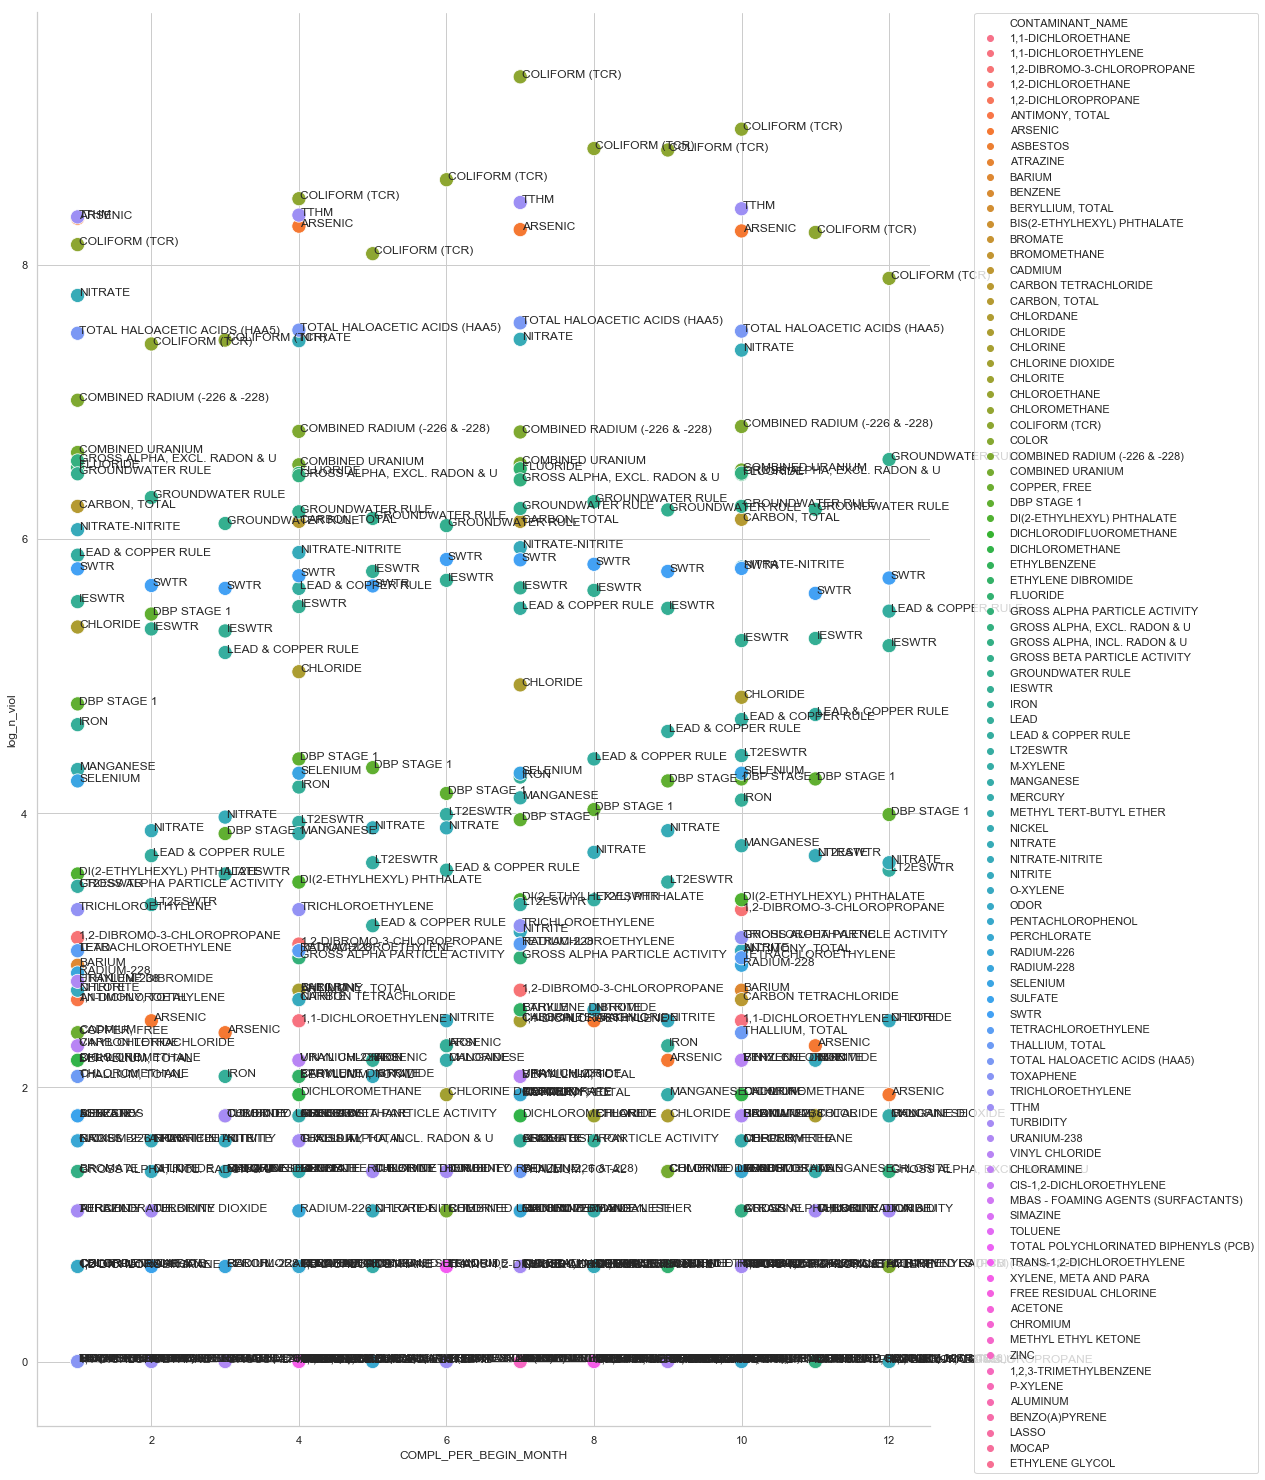

In [97]:
viol_by_month_cont['log_n_viol'] = np.log(viol_by_month_cont['VIOLATION_ID'])

sns.set_style("whitegrid")
plt.figure(figsize=(16, 26))
ax = sns.scatterplot(x="COMPL_PER_BEGIN_MONTH", y="log_n_viol", hue="CONTAMINANT_NAME", data=viol_by_month_cont,
                    s=200)
# g = sns.lineplot(x="COMPL_PER_BEGIN_MONTH", y="log_n_viol", hue="CONTAMINANT_NAME", data=viol_by_month_cont)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(viol_by_month_cont.COMPL_PER_BEGIN_MONTH, viol_by_month_cont.log_n_viol, 
            viol_by_month_cont.CONTAMINANT_NAME, plt.gca())
sns.despine()
plt.show()

In [100]:
viol_by_month_cont.CONTAMINANT_NAME.value_counts()


GROUNDWATER RULE                         12
NITRITE                                  12
CHLORITE                                 12
TURBIDITY                                12
CHLORINE DIOXIDE                         12
MANGANESE                                12
ARSENIC                                  12
LEAD & COPPER RULE                       12
SWTR                                     12
IRON                                     12
COLIFORM (TCR)                           12
CHLORIDE                                 12
DBP STAGE 1                              12
LT2ESWTR                                 12
IESWTR                                   12
NITRATE                                  12
COMBINED RADIUM (-226 & -228)            11
NITRATE-NITRITE                          11
COMBINED URANIUM                         10
GROSS ALPHA, EXCL. RADON & U              9
FLUORIDE                                  9
COLOR                                     9
TTHM                            